### Get Dataset

In [37]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
server = 'DATGUILLE'
database = 'blinkitdb'

connection_string = f'mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+18+for+SQL+Server&Trusted_Connection=yes&TrustServerCertificate=yes'

try:
    engine = create_engine(connection_string)
    print("Conexión exitosa!")
except Exception as e:
    print("Error al conectar:", e)

Conexión exitosa!


In [3]:
with engine.connect() as connection:
    query = text("SELECT * FROM blinkit_data")
    df = pd.read_sql(query, connection)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300000,Low Fat,0.016047,Dairy,249.809204,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.137939
1,DRC01,5.920000,Regular,0.019278,Soft Drinks,48.269199,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.422791
2,FDN15,17.500000,Low Fat,0.016760,Meat,141.617996,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.270020
3,FDX07,19.200001,Regular,0.000000,Fruits and Vegetables,182.095001,OUT010,1998,None,Tier 3,Grocery Store,732.380005
4,NCD19,8.930000,Low Fat,0.000000,Household,53.861401,OUT013,1987,High,Tier 3,Supermarket Type1,994.705200


### 📊 About the Dataset

Below is a description of the features in the dataset:

- **`Item_Identifier`** 🏷️: A unique ID for each product in the dataset.  
- **`Item_Weight`** ⚖️: The weight of the product.  
- **`Item_Fat_Content`** 🥛: Indicates whether the product is low fat or not.  
- **`Item_Visibility`** 👀: The percentage of the total display area in the store allocated to the product.  
- **`Item_Type`** 🛒: The category or type of product.  
- **`Item_MRP`** 💰: The maximum retail price (list price) of the product.  
- **`Outlet_Identifier`** 🏬: A unique ID for each store in the dataset.  
- **`Outlet_Establishment_Year`** 📆: The year in which the store was established.  
- **`Outlet_Size`** 📏: The size of the store in terms of ground area covered.  
- **`Outlet_Location_Type`** 📍: The type of city or region where the store is located.  
- **`Outlet_Type`** 🏪: Indicates whether the store is a grocery store or a supermarket.  
- **`Item_Outlet_Sales`** 📈: The sales of the product in the particular store. This is the outcome variable we want to predict.  


### Data Exploration

In [4]:
df.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300000,Low Fat,0.016047,Dairy,249.809204,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.137939
1,DRC01,5.920000,Regular,0.019278,Soft Drinks,48.269199,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.422791
2,FDN15,17.500000,Low Fat,0.016760,Meat,141.617996,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.270020
3,FDX07,19.200001,Regular,0.000000,Fruits and Vegetables,182.095001,OUT010,1998,None,Tier 3,Grocery Store,732.380005
4,NCD19,8.930000,Low Fat,0.000000,Household,53.861401,OUT013,1987,High,Tier 3,Supermarket Type1,994.705200


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288915
std,4.643457,0.051598,62.275066,8.371760,1706.499616
min,4.555000,0.000000,31.290001,1985.000000,33.290001
25%,8.773750,0.026989,93.826500,1987.000000,834.247406
50%,12.600000,0.053931,143.012802,1999.000000,1794.331055
75%,16.850000,0.094585,185.643700,2004.000000,3101.296387
max,21.350000,0.328391,266.888397,2009.000000,13086.964844


In [7]:
df.describe(include='O')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,5,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5089,1232,935,2793,3350,5577


In [11]:
print(df['Item_Fat_Content'].unique())
print(df['Outlet_Size'].unique())
print(df['Outlet_Location_Type'].unique())
print(df['Outlet_Type'].unique())

['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Medium' None 'High' 'Small']
['Tier 1' 'Tier 3' 'Tier 2']
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [13]:
print(df[df['Item_Weight'].isna()]['Outlet_Identifier'].unique())
# Los items de establecimientos con identificación 'OUT027' y 'OUT019' no tienen un peso asignado.
print(df[(df['Outlet_Identifier']=='OUT027') | (df['Outlet_Identifier']=='OUT019')]['Item_Weight'].unique())

print(df[df['Item_Weight'].isnull()]['Outlet_Establishment_Year'].unique())
# Los items de establecimientos aperturados en el año 1985 no tienen un peso asignado.
print(df[df['Outlet_Establishment_Year']==1985]['Item_Weight'].unique())

['OUT027' 'OUT019']
[nan]
[1985]
[nan]


In [14]:
df[df['Outlet_Size'].isna()].head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200001,Regular,0.000000,Fruits and Vegetables,182.095001,OUT010,1998,None,Tier 3,Grocery Store,732.380005
8,FDH17,16.200001,Regular,0.016687,Frozen Foods,96.972603,OUT045,2002,None,Tier 2,Supermarket Type1,1076.598633
9,FDU28,19.200001,Regular,0.094450,Frozen Foods,187.821396,OUT017,2007,None,Tier 2,Supermarket Type1,4710.535156
25,NCD06,13.000000,Low Fat,0.099887,Household,45.905998,OUT017,2007,None,Tier 2,Supermarket Type1,838.908020
28,FDE51,5.925000,Regular,0.161467,Dairy,45.508598,OUT010,1998,None,Tier 3,Grocery Store,178.434402
30,FDV38,19.250000,Low Fat,0.170349,Dairy,55.795601,OUT010,1998,None,Tier 3,Grocery Store,163.786804
33,FDO23,17.850000,Low Fat,0.000000,Breads,93.143600,OUT045,2002,None,Tier 2,Supermarket Type1,2174.502686
45,FDM39,6.420000,LF,0.089499,Dairy,178.100204,OUT010,1998,None,Tier 3,Grocery Store,358.200409
46,NCP05,19.600000,Low Fat,0.000000,Health and Hygiene,153.302399,OUT045,2002,None,Tier 2,Supermarket Type1,2428.838379
47,FDV49,10.000000,Low Fat,0.025880,Canned,265.222595,OUT045,2002,None,Tier 2,Supermarket Type1,5815.097168


In [17]:
print(df[df['Outlet_Size'].isnull()]['Outlet_Identifier'].unique())
# Los establecimientos identificados como ['OUT010', 'OUT045', 'OUT017'] no tienen un tamaño asignado

print(df[df['Outlet_Size'].isnull()]['Outlet_Location_Type'].unique())
# Los establecimientos sin tamaño asignado tienen un typo de localización ['Tier 3' y 'Tier 2']

['OUT010' 'OUT045' 'OUT017']
['Tier 3' 'Tier 2']


### Data Cleaning

In [18]:
cleaned_df = df.copy()
cleaned_df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300000,Low Fat,0.016047,Dairy,249.809204,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.137939
1,DRC01,5.920000,Regular,0.019278,Soft Drinks,48.269199,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.422791
2,FDN15,17.500000,Low Fat,0.016760,Meat,141.617996,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.270020
3,FDX07,19.200001,Regular,0.000000,Fruits and Vegetables,182.095001,OUT010,1998,None,Tier 3,Grocery Store,732.380005
4,NCD19,8.930000,Low Fat,0.000000,Household,53.861401,OUT013,1987,High,Tier 3,Supermarket Type1,994.705200
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865000,Low Fat,0.056783,Snack Foods,214.521805,OUT013,1987,High,Tier 3,Supermarket Type1,2778.383301
8519,FDS36,8.380000,Regular,0.046982,Baking Goods,108.156998,OUT045,2002,None,Tier 2,Supermarket Type1,549.284973
8520,NCJ29,10.600000,Low Fat,0.035186,Health and Hygiene,85.122398,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.113647
8521,FDN46,7.210000,Regular,0.145221,Snack Foods,103.133202,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.597656


In [19]:
# cleaned_df = cleaned_df.dropna(subset=['Item_Weight']).reset_index(drop=True)
# cleaned_df['Item_Weight'] = cleaned_df['Item_Weight'].fillna(cleaned_df['Item_Weight'].mean())
cleaned_df['Item_Fat_Content'] = cleaned_df['Item_Fat_Content'].replace({
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
})
cleaned_df['Outlet_Size'] = cleaned_df['Outlet_Size'].fillna('Unknown')
# Se completó con "Unknown" los valores "None" para mantener la consistencia de los datos

### Feature Engineering

In [24]:
aggregated_df = cleaned_df.groupby('Item_Identifier', as_index=False).agg({
    'Item_Visibility': 'mean',
    'Item_MRP': 'mean',
    'Item_Outlet_Sales': 'sum',
})
aggregated_df = aggregated_df.rename(columns ={'Item_Outlet_Sales':'Total_Sale'})
aggregated_df['Units_Sold'] = np.floor(aggregated_df['Total_Sale'] / aggregated_df['Item_MRP'])
aggregated_df

,Item_Identifier,Item_Visibility,Item_MRP,Total_Sale,Units_Sold
0,DRA12,0.031956,141.865400,11061.601379,77.0
1,DRA24,0.048062,164.086801,15723.532776,95.0
2,DRA59,0.134718,185.179901,20915.441650,112.0
3,DRB01,0.082126,189.586334,4554.072083,24.0
4,DRB13,0.008002,189.692999,12144.191711,64.0
...,...,...,...,...,...
1554,NCZ30,0.024956,120.752658,12653.529129,104.0
1555,NCZ41,0.051623,125.630402,9137.439148,72.0
1556,NCZ42,0.009044,236.644797,19199.008728,81.0
1557,NCZ53,0.027775,188.321402,15073.712067,80.0


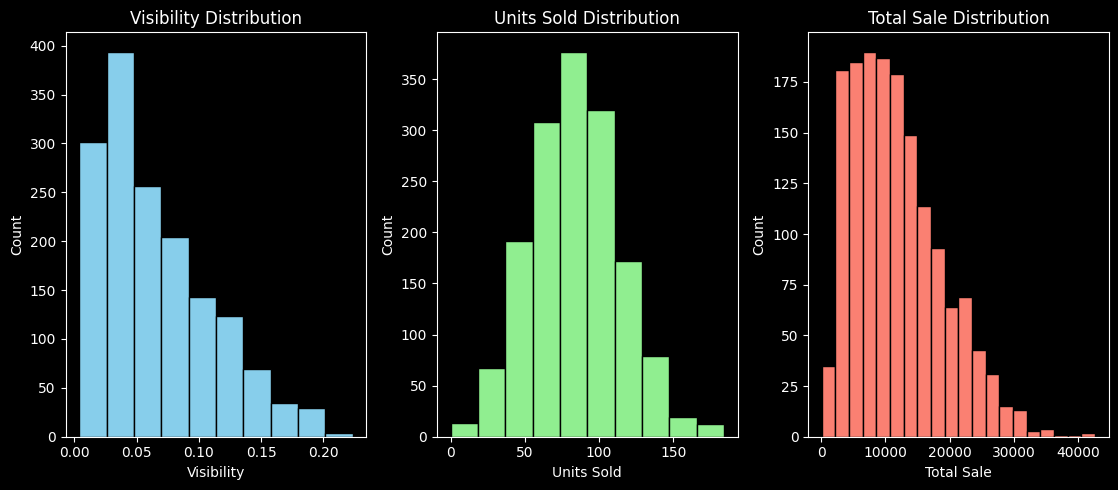

In [54]:

plt.style.use('dark_background')
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.hist(aggregated_df['Item_Visibility'], bins=10, color='skyblue', edgecolor='black')
plt.title('Visibility Distribution')
plt.xlabel('Visibility')
plt.ylabel('Count')

plt.subplot(1, 4, 2)
plt.hist(aggregated_df['Units_Sold'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Units Sold Distribution')
plt.xlabel('Units Sold')
plt.ylabel('Count')

plt.subplot(1, 4, 3)
plt.hist(aggregated_df['Total_Sale'], bins=20, color='salmon', edgecolor='black')
plt.title('Total Sale Distribution')
plt.xlabel('Total Sale')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

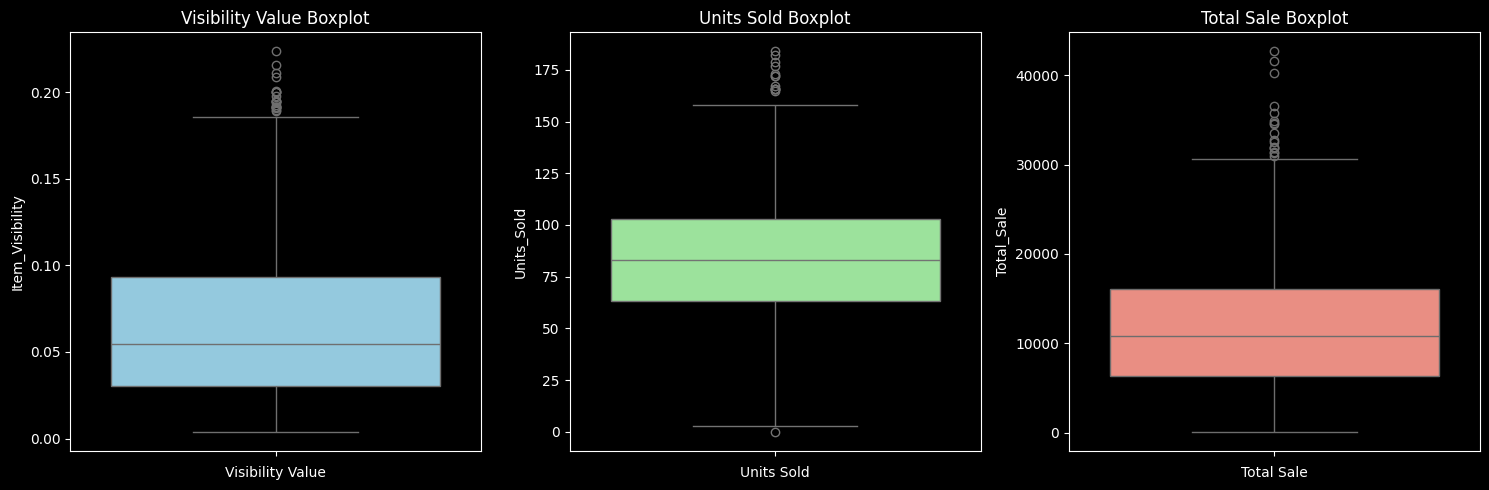

In [55]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['Item_Visibility'], color='skyblue')
plt.title('Visibility Value Boxplot')
plt.xlabel('Visibility Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Units_Sold'], color='lightgreen')
plt.title('Units Sold Boxplot')
plt.xlabel('Units Sold')

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Total_Sale'], color='salmon')
plt.title('Total Sale Boxplot')
plt.xlabel('Total Sale')

plt.tight_layout()
plt.show()

In [44]:
M_Q1 = aggregated_df["Item_Visibility"].quantile(0.25)
M_Q3 = aggregated_df["Item_Visibility"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

visibility_outliers_df = aggregated_df[(aggregated_df["Item_Visibility"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["Item_Visibility"] < (M_Q1 - 1.5 * M_IQR))].copy()
visibility_outliers_df.describe()

,Item_Visibility,Item_MRP,Total_Sale,Units_Sold
count,22.000000,22.000000,22.000000,22.000000
mean,0.198019,128.323937,9587.187087,74.954545
std,0.009106,61.418028,6687.072213,30.435689
min,0.189104,34.207401,120.509804,0.000000
25%,0.191470,72.045799,4643.788542,54.000000
50%,0.194607,133.176668,7577.136879,84.500000
75%,0.200143,170.719190,15025.108498,98.500000
max,0.223469,241.801201,23571.983398,110.000000


In [47]:
M_Q1 = aggregated_df["Total_Sale"].quantile(0.25)
M_Q3 = aggregated_df["Total_Sale"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

Total_Sales_outliers_df = aggregated_df[(aggregated_df["Total_Sale"] > (M_Q3 + 1.5 * M_IQR)) | (aggregated_df["Total_Sale"] < (M_Q1 - 1.5 * M_IQR))].copy()
Total_Sales_outliers_df.describe()

,Item_Visibility,Item_MRP,Total_Sale,Units_Sold
count,17.000000,17.000000,17.000000,17.000000
mean,0.035491,245.819157,34633.858497,140.588235
std,0.021216,15.447049,3674.612088,13.295012
min,0.015473,211.078515,30958.368286,120.000000
25%,0.018926,231.265066,31873.177307,133.000000
50%,0.025712,253.344801,33531.019653,137.000000
75%,0.050893,257.273800,35741.475830,149.000000
max,0.081125,263.219570,42661.801666,166.000000


In [48]:
non_outliers_df = aggregated_df[(~aggregated_df.index.isin(visibility_outliers_df.index)) & (~aggregated_df.index.isin(Total_Sales_outliers_df.index))]
non_outliers_df.describe()

,Item_Visibility,Item_MRP,Total_Sale,Units_Sold
count,1520.000000,1520.000000,1520.000000,1520.000000
mean,0.064106,140.022009,11704.889282,83.301316
std,0.041999,61.439816,6644.219274,29.419241
min,0.003981,32.315000,332.900009,3.000000
25%,0.030415,93.634300,6308.787918,63.000000
50%,0.053399,141.689506,10716.050938,82.000000
75%,0.091889,184.553453,15755.657692,102.250000
max,0.185806,265.468390,30584.188904,184.000000


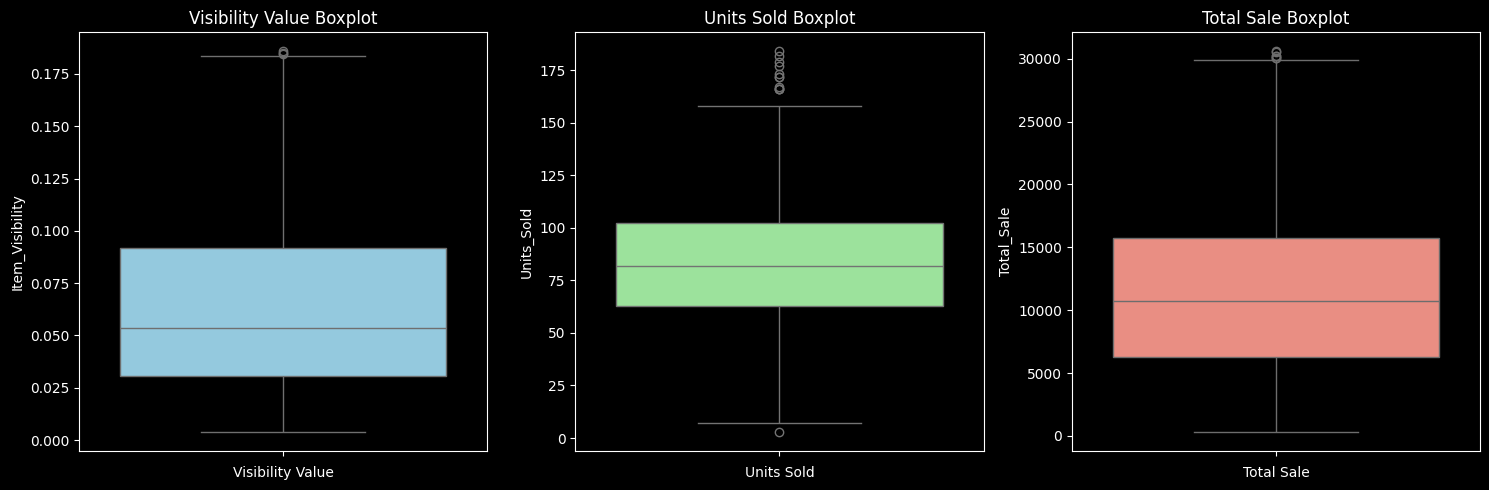

In [56]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=non_outliers_df['Item_Visibility'], color='skyblue')
plt.title('Visibility Value Boxplot')
plt.xlabel('Visibility Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=non_outliers_df['Units_Sold'], color='lightgreen')
plt.title('Units Sold Boxplot')
plt.xlabel('Units Sold')

plt.subplot(1, 3, 3)
sns.boxplot(data=non_outliers_df['Total_Sale'], color='salmon')
plt.title('Total Sale Boxplot')
plt.xlabel('Total Sale')

plt.tight_layout()
plt.show()

In [ ]:

def prepare_and_scale_data(df, features_numeric):
    """
    Parameters:
    df: DataFrame
    features_numeric: List of numerical columns

    Returns:
    X_scaled: Scaled numerical data 
    feature_names: List of names of all processed features
    """
    X_numeric = df[features_numeric]

    scaler = StandardScaler()
    X = np.hstack((X_numeric))
    
    X_scaled = scaler.fit_transform(X_numeric)
    feature_names = features_numeric

    return X_scaled, feature_names


def analyze_store_data(df):
    def elbow_method_for_kmeans(data):
        cluster_range = range(2, 11)
        inertia_values = []
        silhouette_scores = []
        
        for n_clusters in cluster_range:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans.fit(data)
            inertia_values.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
            
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Elbow Method
        ax1.plot(cluster_range, inertia_values, marker='o')
        ax1.set_xlabel('Cluster count (k)')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method')
        
        # Silhouette score
        ax2.plot(cluster_range, silhouette_scores, marker='o')
        ax2.set_xlabel('Cluster count (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Score by cluster count')
        
        plt.tight_layout()
        plt.show()
        
        return inertia_values, silhouette_scores

    # 1. SEGMENTACIÓN DE PRODUCTOS
    def segment_products(df):
        # Preparar datos para clustering de productos
        item_features = {
            'numeric_features': [
                'Item_Visibility',
                'Total_Sale',
                'Units_Sold'
            ]
        }

        X_scaled, feature_names = prepare_and_scale_data(
            df,
            item_features['numeric_features'],
        )

        # Aplicar K-means
        kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
        df['Cluster'] = kmeans.fit_predict(X_scaled)

        # Analizar clusters
        cluster_stats = df.groupby('Cluster').agg({
            'Item_Visibility': 'sum',
            'Units_Sold': 'sum',
            'Total_Sale': 'sum'
        }).round(2)

        elbow_method_for_kmeans(X_scaled)

        return df, cluster_stats

    product_segments, product_stats = segment_products(df)

    return {
        'product_segments': product_segments,
        'product_stats': product_stats,
    }

def visualize_clusters(df, features_numeric, cluster_labels, title="Cluster Visualization"):
    X_scaled, feature_names = prepare_and_scale_data(
        df,
        features_numeric
    )

    fig = plt.figure(figsize=(15, 6))

    # Plot 2D
    ax1 = fig.add_subplot(121)
    scatter = ax1.scatter(X_scaled[:, 0], X_scaled[:, 1],
                         c=cluster_labels, cmap='viridis', alpha=0.7)
    ax1.set_title(f'{title} (2D)')
    ax1.set_xlabel(feature_names[0])
    ax1.set_ylabel(feature_names[1])
    plt.colorbar(scatter, ax=ax1, label='Cluster')

    # Plot 3D
    ax2 = fig.add_subplot(122, projection='3d')
    scatter = ax2.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2],
                            c=cluster_labels, cmap='viridis', alpha=0.7)
    ax2.set_title(f'{title} (3D)')
    ax2.set_xlabel(feature_names[0])
    ax2.set_ylabel(feature_names[1])
    ax2.set_zlabel(feature_names[2] if len(feature_names) > 2 else "Feature 3")
    plt.colorbar(scatter, ax=ax2, label='Cluster')

    plt.tight_layout()
    plt.show()

def visualize_product_clusters(product_segments):
    features_numeric = [
        'Item_Visibility',
        'Units_Sold',
        'Total_Sale'
    ]

    visualize_clusters(
        product_segments,
        features_numeric,
        product_segments['Cluster'],
        "Segmentación de Productos"
    )

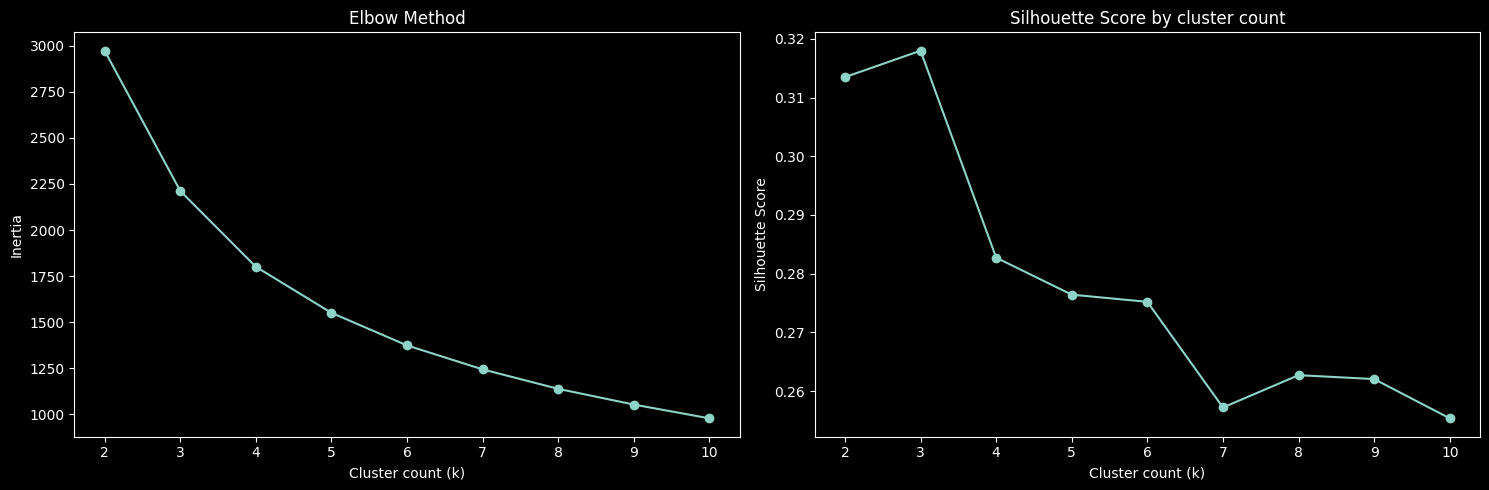

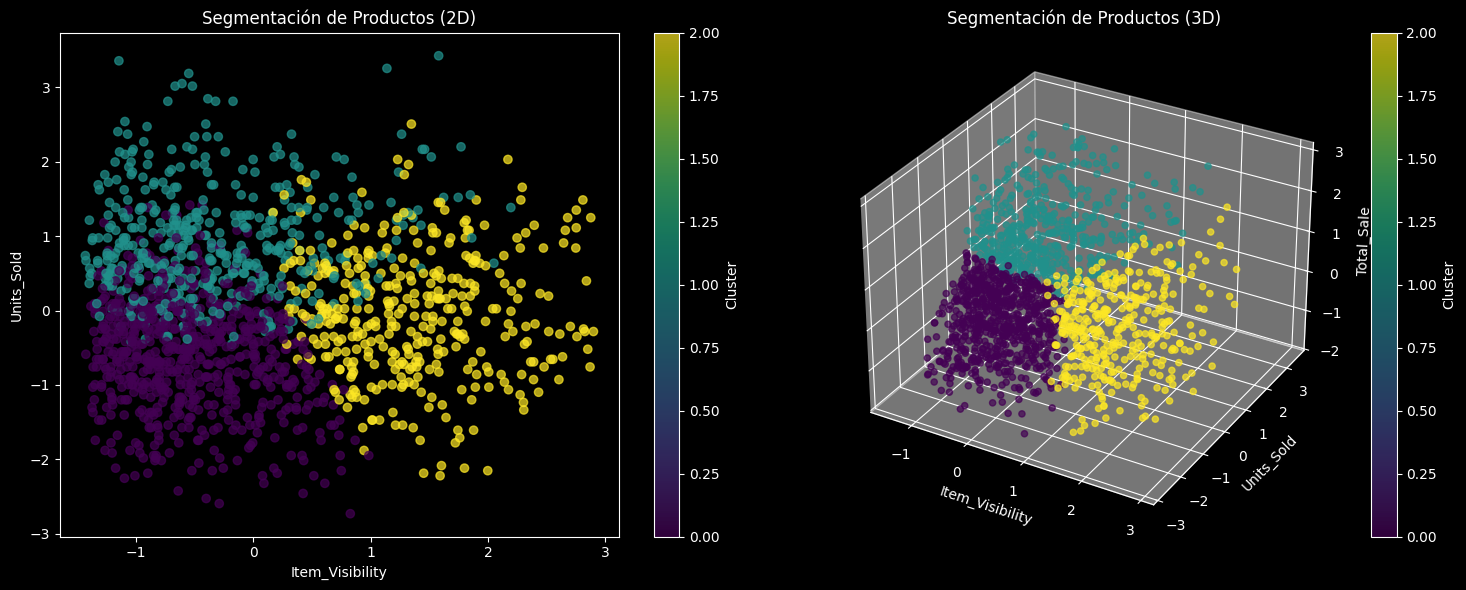

,Item_Visibility,Units_Sold,Total_Sale
Cluster,,,
0,28.71,45200.0,5357500.19
1,23.50,50858.0,8595155.75
2,45.23,30560.0,3838775.77


In [57]:
analysis_results = analyze_store_data(non_outliers_df.copy())
product_segments = analysis_results['product_segments']
visualize_product_clusters(product_segments)
analysis_results['product_stats']

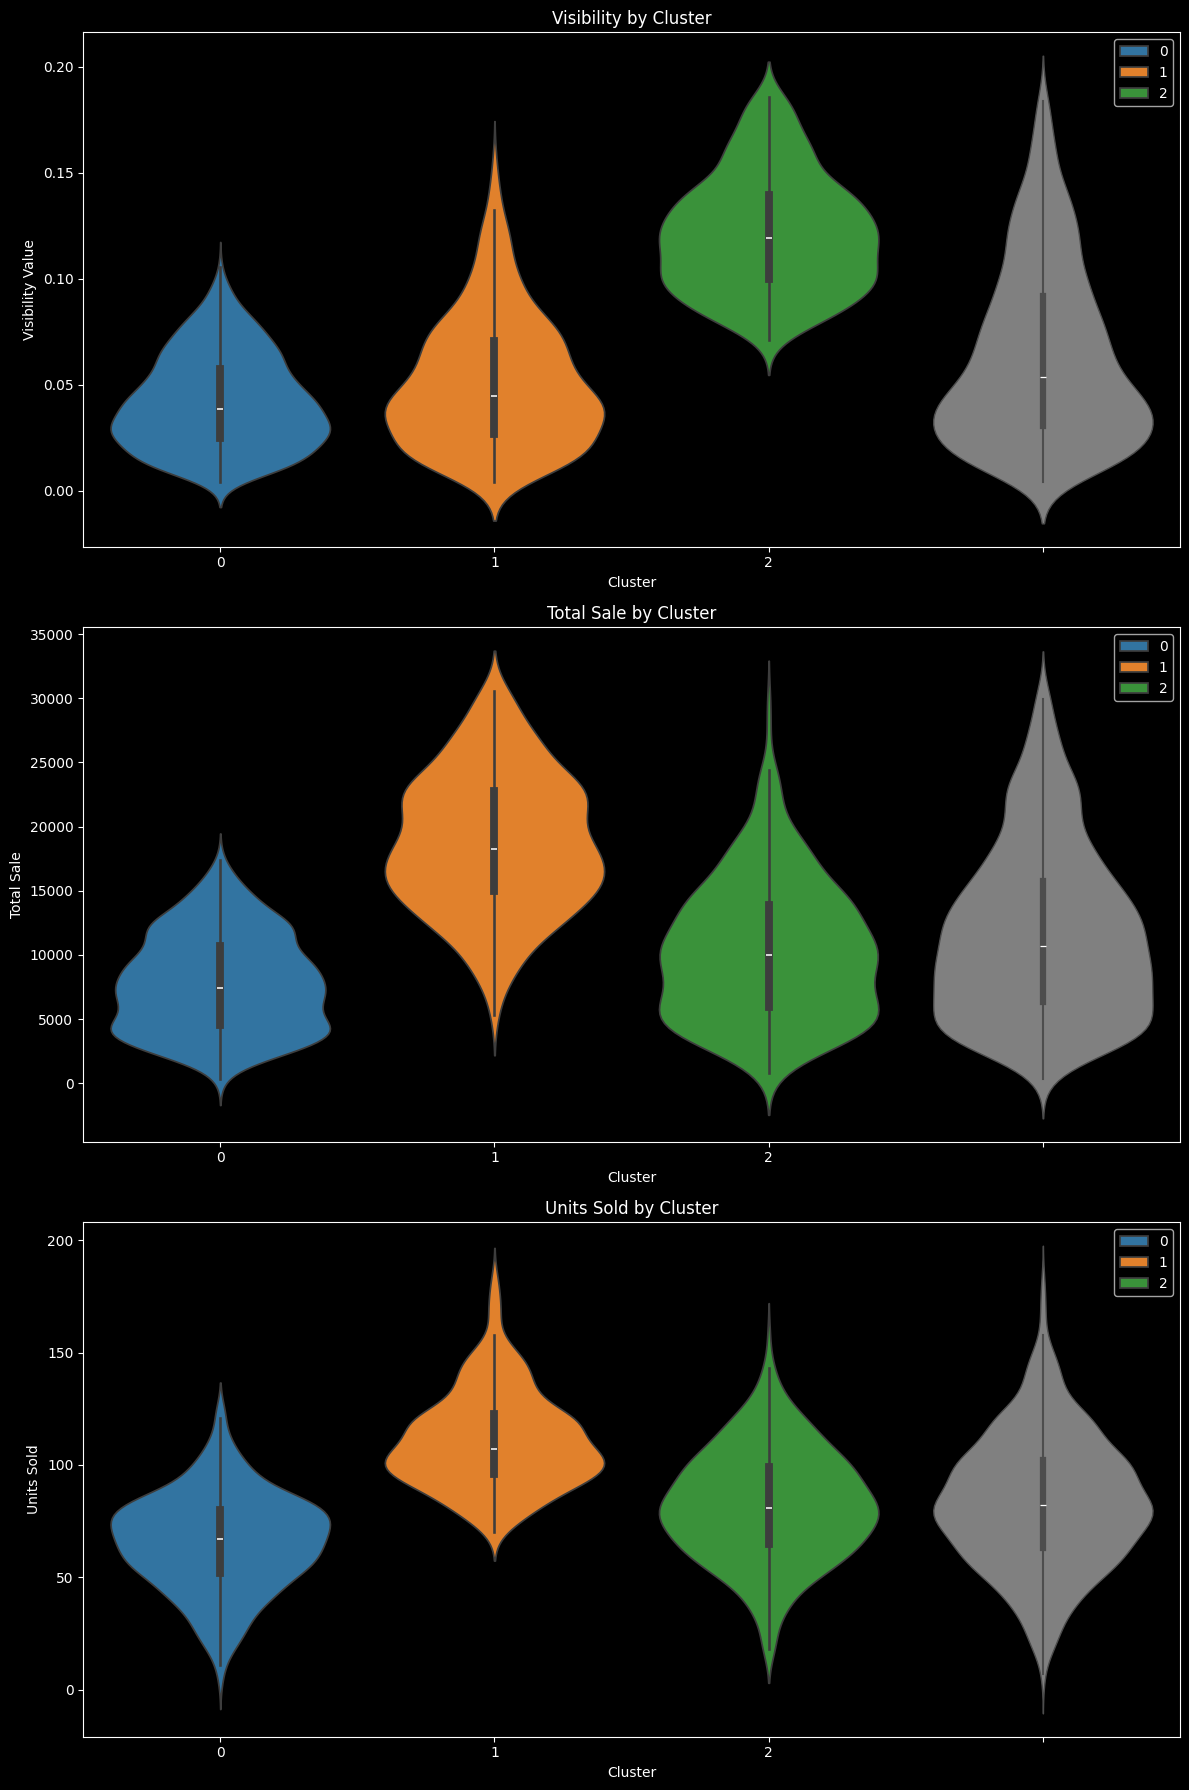

In [58]:
cluster_colors = {0: '#1f77b4',  # Blue
                  1: '#ff7f0e',  # Orange
                  2: '#2ca02c',  # Green
                }
plt.figure(figsize=(12, 18))

plt.subplot(3, 1, 1)
sns.violinplot(x=analysis_results['product_segments']['Cluster'], y=analysis_results['product_segments']['Item_Visibility'], palette=cluster_colors, hue=analysis_results['product_segments']["Cluster"])
sns.violinplot(y=analysis_results['product_segments']['Item_Visibility'], color='gray', linewidth=1.0)
plt.title('Visibility by Cluster')
plt.ylabel('Visibility Value')

plt.subplot(3, 1, 2)
sns.violinplot(x=analysis_results['product_segments']['Cluster'], y=analysis_results['product_segments']['Total_Sale'], palette=cluster_colors, hue=analysis_results['product_segments']["Cluster"])
sns.violinplot(y=analysis_results['product_segments']['Total_Sale'], color='gray', linewidth=1.0)
plt.title('Total Sale by Cluster')
plt.ylabel('Total Sale')


plt.subplot(3, 1, 3)
sns.violinplot(x=analysis_results['product_segments']['Cluster'], y=analysis_results['product_segments']['Units_Sold'], palette=cluster_colors, hue=analysis_results['product_segments']["Cluster"])
sns.violinplot(y=analysis_results['product_segments']['Units_Sold'], color='gray', linewidth=1.0)
plt.title('Units Sold by Cluster')
plt.ylabel('Units Sold')

plt.tight_layout()
plt.show()

- **``Cluster 0 (Blue)``**: Performance Optimization

    ``Rationale``: Lower total sales and units sold compared to other clusters. Products with current underperformance.

    ``Strategy``: Optimize. Deep analysis to identify causes of low performance. Review marketing, visibility, promotions, and pricing. Consider product reformulation.

- **``Cluster 1 (Orange)``**: Sales Acceleration

    ``Rationale``: Maximum total sales and units sold. High-performance products with significant revenue contribution.
    
    ``Strategy``: Maximize. Ensure consistent stock. Implement cross-selling/up-selling. Optimize pricing for profitability without affecting volume.

- **``Cluster 2 (Green)``**: Consolidation and Growth

    ``Rationale``: Relatively high total sales and stable performance. Products with good sales foundation but below maximum performers.

    ``Strategy``: Consolidate and Grow. Build customer loyalty through exclusive promotions. Research line extensions and presentation improvements. Strengthen branding to increase perceived value.